## Insights : Manutenção Preditiva Máquinas

Este notebook traz insights e análises a partir dos dados trabalhados no desafio e o contexto de manutenção de máquinas.

⛴ As máquinas industriais e equipamentos em geral possuem um tempo de vida útil.

⏱ Esse tempo diz respeito ao bom funcionamento da máquina: quando falha já acabou o tempo de vida útil.

⁉ As máquinas podem apresentar defeitos e falhas. O defeito pode prejudicar o funcionamento da máquina mas não impedir que ela funcione. Já a falha é quando ela passa a apresentar uma incapacidade de funcionar e precisa de manutenção.

☑ O contexto do problema trata da manutenção preditiva. Esta é feita de modo a recuperar as máquinas após apresentarem as falhas. Em termos econômicos pode ser vantajosa caso os equipamentos apresentem um longo tempo de vida útil.
Já a manutenção preventiva é feita de forma periódica. Apesar de ter um custo previsto por período, ela tende a prolongar o tempo de vida útil do equipamento, trazendo vantagem a longo prazo.


🛁 No geral os equipamentos seguem a chamada curva da banheira. Alguns apresentam falhas antes e depois do que é esperado ao tempo de vida útil, o que seriam as extremidades da banheira. Já o meio segue ao funcionamento esperado. Isso tem relação com as distribuições estatísticas para as falhas nesses períodos. A seguir a lista das classes de falhas e um exemplo de gráfico de curva da banheira:

* falhas iniciais
* falhas no período de vida útil
* falhas por desgaste

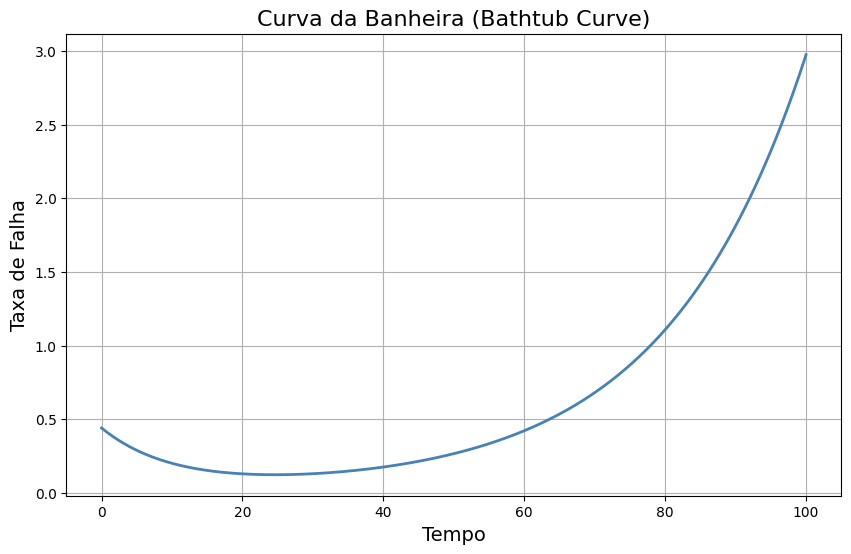

In [5]:
#exemplo de como seria a curva da banheira
import numpy as np
import matplotlib.pyplot as plt

tempo = np.linspace(0, 100, 500)
falha_inicial = 0.4 * np.exp(-0.1 * tempo)
falha_util = 0.02 * np.ones_like(tempo)
falha_desgaste = 0.4 * np.exp(0.05 * (tempo - 60))
taxa_falha = falha_inicial + falha_util + falha_desgaste

# Plot
plt.figure(figsize=(10,6))
plt.plot(tempo, taxa_falha, color='steelblue', linewidth=2)
plt.title("Curva da Banheira (Bathtub Curve)", fontsize=16)
plt.xlabel("Tempo", fontsize=14)
plt.ylabel("Taxa de Falha", fontsize=14)
plt.grid(True)
plt.show()


No desafio estudamos um conjunto de dados que apresenta algumas características das máquinas e do ambiente tais quais a temperatura do ar e o torque e velocidade de rotação da máquina, dentre outras. Essas características são fatores que podem relevar o que é um possível indicador para a falha da máquina. A seguir tem-se uma amostra dos dados para visualizar-mos essas características:


In [9]:
import pandas as pd
df = pd.read_csv('/content/bootcamp_train_1.csv')
df = df.drop(columns=['Unnamed: 0'])
df.head(2)

,id,tipo,tempA,tempP,umiR,velR,torque,desgF,F,FDF,FDC,FP,FTE,FAL
0,L56434,L,298.3,309.1,90.0,1616.0,31.1,195.0,não,False,False,Não,False,Não
1,L48741,L,298.2,308.4,90.0,1388.0,53.8,137.0,Não,False,False,Não,False,Não


Logo, pelo contexto dos dados, supoe-se que variáveis como temperatura do ar e do processo, umidade relativa, velocidade de rotação, torque, desgaste podem todas ter relação com a ocorrência de falha na máquina. Não há registros de dados de tempo. Entende-se que o foco aqui é predizer o que causou a falha.

Neste cenário, a engenharia de manutenção é uma ferramenta para ajudar a mapear possíveis tempos esperados até a ocorrência da falha, e a aplicação da ciência de dados pode ajudar a entender o que levou a essa falha, ambas auxiliando as empresas na tomada de decisão com relação as manutenções dos equipamentos.

Vale lembrar que no nosso estudo de caso constatamos que a falha com maior chance de ocorrência é a Falha por Dissipação de Calor.

Esta é uma falha que pode ser proveniente da degradação de materiais, perda de lubrificação, etc. Um outro ponto é que deformações mencânicas podem gerar um desgaste prematuro. Isso é muito importante quando relacionamos com a curva da banheira pois essa **causa da falha** pode gerar a **falha prematura** e impactar no tempo de vida útil do equipamento.

Assim, trabalhar com esse conjunto pode ajudar a prever a falha e apoiar decisões relativas a manutenção como: possíveis tendências a falhas prematuras e impactos no tempo de vida útil que exigiram **custos alocados a manutenção**.

Sabe-se também que tudo isso, dependendo de onde for utilizada a máquina, pode impactar em desenvolvimento de tarefas dos mais diversos setores, sejam de fábricas por exemplo, que podem produzir bens essenciais a sociedade. Isso ratifica a importância da manutenção das máquinas e de um bom monitoramento dos custos com elas. Podem impactar na satisfação do cliente também.


Para a análise melhorias futuras podem ser vistas, como estudo da deformação mecânica dos equipamentos e estudos sobre os materiais adotados.

Analisando a ocorrência da falha ou não e os fatores, usaremos técnica de clusterização para identificar padrões no comportamento dos dados e a classificação binária (falha ou não falha).

In [25]:
!mkdir figuras_insights/

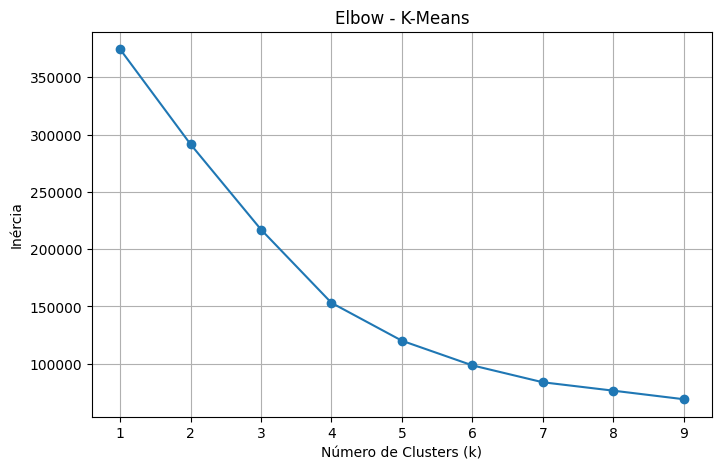

<Figure size 640x480 with 0 Axes>

In [26]:
#--Preparação do ambiente
#!pip install scikit-learn imbalanced-learn
#imports
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.multioutput import MultiOutputClassifier
from scipy.spatial.distance import mahalanobis
#from sklearn.svm import SVC
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#from sklearn.datasets import load_iris, make_multilabel_classification
from scipy import stats
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDOneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import time
from sklearn.cluster import KMeans

#--Data
#from google.colab import files
#uploaded = files.upload()
file = '/content/bootcamp_train_2_df_treated_2.csv' #outliers tratados
df= pd.read_csv(file)
#Classificação binária
df = df.drop(columns=['Unnamed: 0','FDF', 'FDC', 'FP', 'FTE', 'FAL'])

#analisando relação das features com desgaste
features = ['tempA', 'tempP', 'umiR', 'velR', 'torque']
scaler = QuantileTransformer(output_distribution="normal", random_state=42)
df_scaled = scaler.fit_transform(df[features])

#traçando elbow para k-means para ver quantos grupos escolher
inertias = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), inertias, marker='o')
plt.title('Elbow - K-Means')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.grid(True)
plt.show()
plt.savefig('/content/figuras_insights/elbow_desgaste.png')

In [18]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(df_scaled)
#resultados agrupamentos
print("--Métricas de degradação por Cluster--")
print(df.groupby('cluster').mean())
print("\nMédia de desgaste por Cluster:")
print(df.groupby('cluster')['desgF'].mean())

--Métricas de degradação por Cluster--
                  id      tipo       tempA       tempP       umiR  \
cluster                                                             
0        4710.630255  0.531312  299.327421  309.335803  89.997796   
1        4658.062288  0.524577  269.505715  278.561346  90.001985   
2        4771.925191  0.532811  -36.000000  278.966748  89.990009   
3        4743.060066  0.532726  299.242916  -38.000000  90.000000   

                velR     torque      desgF         F  
cluster                                               
0        1515.298113  40.232681  78.851470  0.019458  
1        1143.500000  40.210032  80.497766  0.017265  
2        1515.009677  40.089144  79.093946  0.013222  
3        1515.494977  40.047411  78.248882  0.019056  

Média de desgaste por Cluster:
cluster
0    78.851470
1    80.497766
2    79.093946
3    78.248882
Name: desgF, dtype: float64


O cluster de maior desgaste médio foi o 1. Nota-se que features como umidade foi mais alta e a velocidade foi mais baixa.

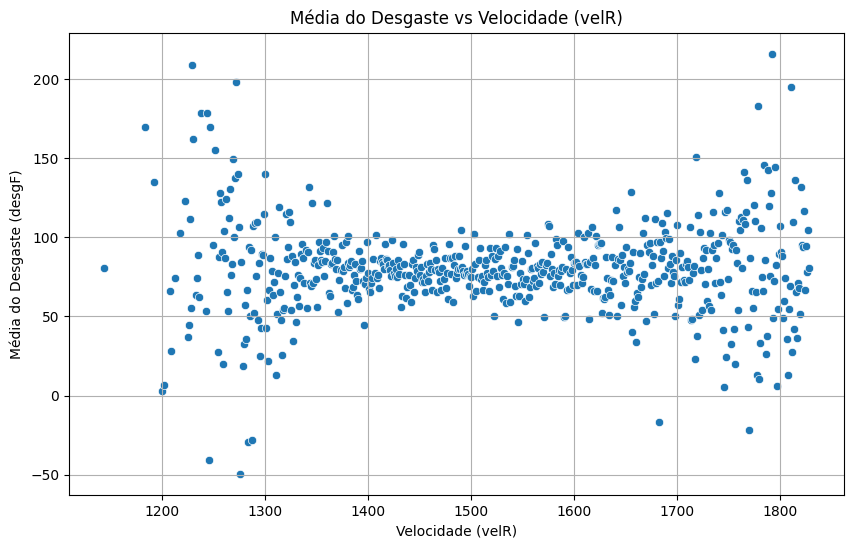

<Figure size 640x480 with 0 Axes>

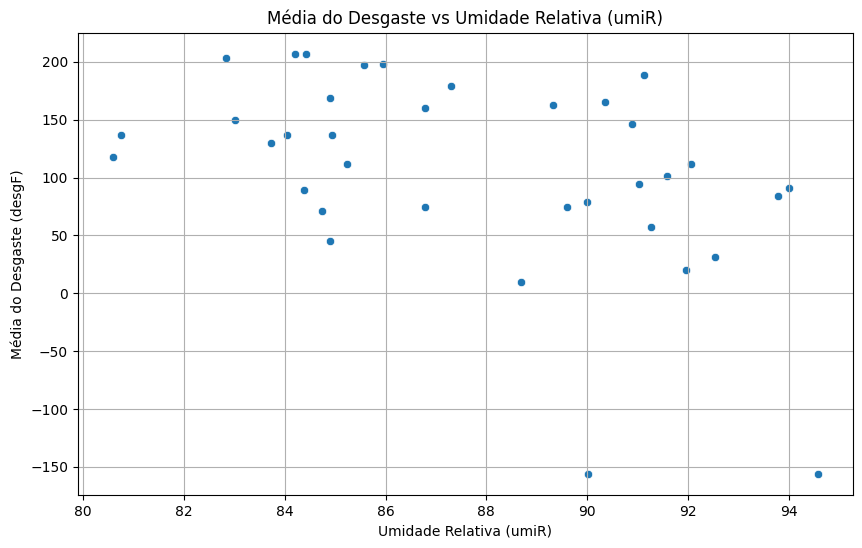

<Figure size 640x480 with 0 Axes>

In [28]:
#média do desgaste por velocidade
mean_desgF_by_velR = df.groupby('velR')['desgF'].mean().reset_index()
#Plot média do desgaste por velocidade
plt.figure(figsize=(10, 6))
sns.scatterplot(data=mean_desgF_by_velR, x='velR', y='desgF')
plt.title('Média do Desgaste vs Velocidade (velR)')
plt.xlabel('Velocidade (velR)')
plt.ylabel('Média do Desgaste (desgF)')
plt.grid(True)
plt.show()
plt.savefig('/content/figuras_insights/desgaste_media_velocidade.pdf')
#média do desgaste por umiR
mean_desgF_by_umiR = df.groupby('umiR')['desgF'].mean().reset_index()
#Plot média do desgaste por umiR
plt.figure(figsize=(10, 6))
sns.scatterplot(data=mean_desgF_by_umiR, x='umiR', y='desgF')
plt.title('Média do Desgaste vs Umidade Relativa (umiR)')
plt.xlabel('Umidade Relativa (umiR)')
plt.ylabel('Média do Desgaste (desgF)')
plt.grid(True)
plt.show()
plt.savefig('/content/figuras_insights/desgaste_media_umiR.pdf')

**☑ Por fim concluímos dentre os insights extraídos do estudo sumarizados:**

* que a engenharia de manutenção auxilia a prever a ocorrência da próxima falha, mas a ciência de dados pode auxiliar a detectar a causa raíz, qual a feature que levou a falha no equipamento.

* a falha mais provável de ocorrer é a por dissipação de calor

* a falha menos provável de ocorrer é a falha aleatória

* O desgaste dos equipamentos tem reflexo na velocidade de rotação, que tende a diminui

* a falha por dissipação de calor é resultate da degradação de materiais

* a degradação de materiais pode ocorrer de forma prematura, o que reduz o tempo de vida útil do equipamento

* com a redução do tempo de vida útil do equipamento a falha pode ocorrer prematuramente

* a manutenção do equipamento sendo feita na causa raiz da falha e no período certo podem auxiliar na redução de custos de manutenção e aumento do tempo de vida útil do equipamento.

In [30]:
#download zip imagens
!zip -r figuras_insights.zip figuras_insights/

  adding: figuras_insights/ (stored 0%)
  adding: figuras_insights/desgaste_media_velocidade.pdf (deflated 49%)
  adding: figuras_insights/elbow_desgaste.png (deflated 90%)
  adding: figuras_insights/.zip (stored 0%)
  adding: figuras_insights/desgaste_media_umiR.pdf (deflated 49%)
